### Import des bibliothèques

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set()


from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

# !pip install yellowbrick
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import OrdinalEncoder


from sklearn.preprocessing import LabelEncoder

from sklearn.decomposition import PCA

### Chargement des données 

In [3]:
catalogue = pd.read_csv("../data/processed/catalogue_processed.csv")


### Prétraitement des données

In [4]:
catalogue.head()

,marque,nom,puissance,longueur,nbPlaces,nbPortes,couleur,occasion,prix
0,Volvo,S80 T6,272,très longue,5,5,blanc,False,50500
1,Volvo,S80 T6,272,très longue,5,5,noir,False,50500
2,Volvo,S80 T6,272,très longue,5,5,rouge,False,50500
3,Volvo,S80 T6,272,très longue,5,5,gris,True,35350
4,Volvo,S80 T6,272,très longue,5,5,bleu,True,35350


In [5]:
catalogue.describe()

,puissance,nbPlaces,nbPortes,prix
count,270.000000,270.000000,270.000000,270.000000
mean,157.592593,5.222222,4.814815,26668.055556
std,90.551289,0.629707,0.580798,19050.121112
min,55.000000,5.000000,3.000000,7500.000000
25%,109.000000,5.000000,5.000000,16029.000000
50%,147.000000,5.000000,5.000000,20597.500000
75%,170.000000,5.000000,5.000000,30000.000000
max,507.000000,7.000000,5.000000,101300.000000


In [6]:
# Séparer les voitures neuves et d'occasion
catalogue_new      = catalogue[catalogue["occasion"] == False]
catalogue_occasion = catalogue[catalogue["occasion"] == True]

In [7]:
# Supprimer les doublons des voitures neuves en fonction du nom
catalogue_new = catalogue_new.drop_duplicates(subset=['nom'])
catalogue_new.describe()


,puissance,nbPlaces,nbPortes,prix
count,32.000000,32.000000,32.000000,32.000000
mean,151.093750,5.250000,4.812500,28744.687500
std,87.607394,0.672022,0.592289,20997.041878
min,55.000000,5.000000,3.000000,7500.000000
25%,102.750000,5.000000,5.000000,17762.500000
50%,135.500000,5.000000,5.000000,24340.000000
75%,166.250000,5.000000,5.000000,30710.000000
max,507.000000,7.000000,5.000000,101300.000000


In [8]:
catalogue_new['longueur'].unique()

array(['très longue', 'longue', 'courte', 'moyenne'], dtype=object)

In [9]:
# Définir l'ordre des catégories
ordre_longueur = ['courte', 'moyenne', 'longue', 'très longue']

# Initialiser le OrdinalEncoder avec l'ordre spécifié
encoder = OrdinalEncoder(categories=[ordre_longueur])

# Appliquer l'encodage ordinal à la colonne 'longueur'
catalogue_new['longueur'] = encoder.fit_transform(catalogue_new[['longueur']])

# Vérifier les résultats
catalogue_new[['longueur']].head()

,longueur
0,3.0
10,2.0
21,0.0
35,1.0
45,1.0


In [10]:
catalogue_new.head()

,marque,nom,puissance,longueur,nbPlaces,nbPortes,couleur,occasion,prix
0,Volvo,S80 T6,272,3.0,5,5,blanc,False,50500
10,Volkswagen,Touran 2.0 FSI,150,2.0,7,5,rouge,False,27340
21,Volkswagen,Polo 1.2 6V,55,0.0,5,3,blanc,False,12200
35,Volkswagen,New Beatle 1.8,110,1.0,5,5,rouge,False,26630
45,Volkswagen,Golf 2.0 FSI,150,1.0,5,5,blanc,False,22900


In [11]:
# Sélectionner uniquement les colonnes numériques
X = catalogue_new.select_dtypes(include=['float64', 'int64'])

In [12]:
X.head()

,puissance,longueur,nbPlaces,nbPortes,prix
0,272,3.0,5,5,50500
10,150,2.0,7,5,27340
21,55,0.0,5,3,12200
35,110,1.0,5,5,26630
45,150,1.0,5,5,22900


### Clustering

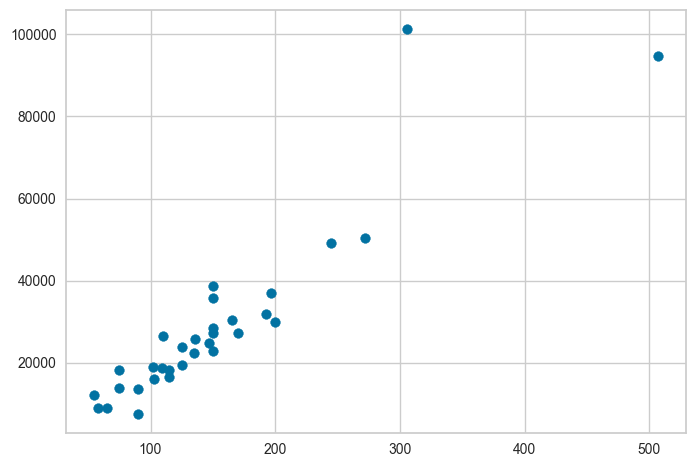

In [13]:
plt.scatter (X["puissance"], X["prix"])

In [14]:
# Normalizing the columns using apply with lambda function
# X_norm = X.apply(lambda col: (col - col.mean()) / col.std())

# Normalisation des attributs à l'aide du z-score

def normalize (x) :
    return (x-np.mean(x))/np.std(x)
X_norm = pd.DataFrame()
X_norm["puissance"] = normalize (X.puissance)
X_norm["nbPlaces"]  = normalize (X.nbPlaces)
X_norm["nbPortes"]  = normalize (X.nbPortes)
X_norm["longueur"]  = normalize (X.longueur)
X_norm["prix"] = normalize (X.prix)

In [15]:
X_norm.head()

,puissance,nbPlaces,nbPortes,longueur,prix
0,1.402175,-0.377964,0.321634,1.455214,1.052692
10,-0.012684,2.645751,0.321634,0.485071,-0.067970
21,-1.114419,-0.377964,-3.109126,-1.455214,-0.800561
35,-0.476573,-0.377964,0.321634,-0.485071,-0.102325
45,-0.012684,-0.377964,0.321634,-0.485071,-0.282812


In [16]:
X_norm.describe()

,puissance,nbPlaces,nbPortes,longueur,prix
count,3.200000e+01,3.200000e+01,3.200000e+01,3.200000e+01,3.200000e+01
mean,2.775558e-17,-2.775558e-17,-2.775558e-17,6.938894e-18,-3.469447e-17
std,1.016001e+00,1.016001e+00,1.016001e+00,1.016001e+00,1.016001e+00
min,-1.114419e+00,-3.779645e-01,-3.109126e+00,-1.455214e+00,-1.027984e+00
25%,-5.606524e-01,-3.779645e-01,3.216338e-01,-4.850713e-01,-5.314041e-01
50%,-1.808439e-01,-3.779645e-01,3.216338e-01,4.850713e-01,-2.131332e-01
75%,1.757702e-01,-3.779645e-01,3.216338e-01,4.850713e-01,9.509718e-02
max,4.127518e+00,2.645751e+00,3.216338e-01,1.455214e+00,3.510793e+00


In [17]:
X_norm.corr()

,puissance,nbPlaces,nbPortes,longueur,prix
puissance,1.000000,-0.067257,0.311187,0.716720,0.914135
nbPlaces,-0.067257,1.000000,0.121566,0.183340,-0.099577
nbPortes,0.311187,0.121566,1.000000,0.468046,0.268122
longueur,0.716720,0.183340,0.468046,1.000000,0.651152
prix,0.914135,-0.099577,0.268122,0.651152,1.000000


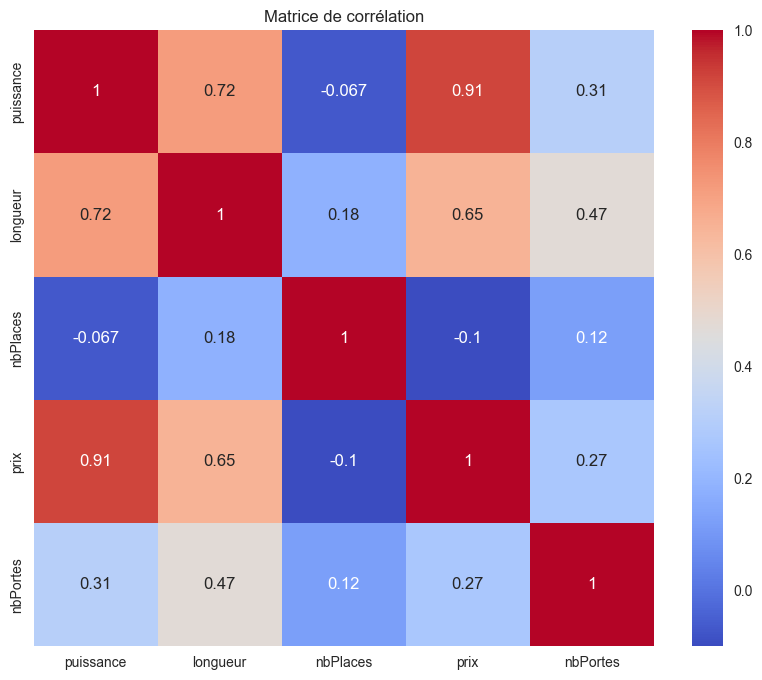

In [18]:
# Matrice de corrélation
plt.figure(figsize=(10, 8))
sns.heatmap(X_norm[['puissance','longueur','nbPlaces','prix','nbPortes']].corr(), annot=True, cmap='coolwarm')
plt.title('Matrice de corrélation')
plt.show()


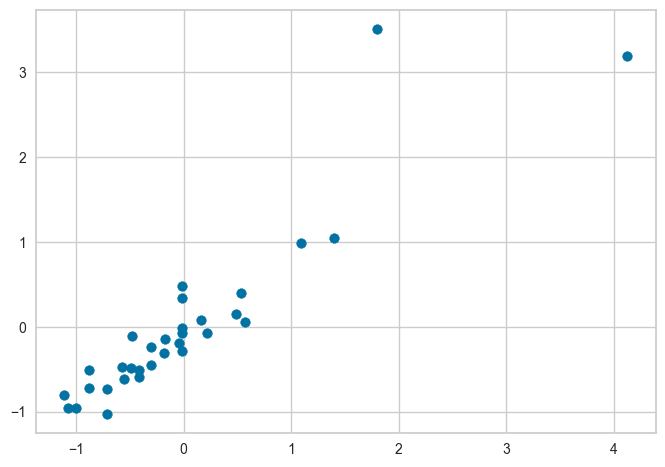

In [19]:
plt.scatter (X_norm["puissance"], X_norm["prix"])

In [20]:
X_norm.columns

Index(['puissance', 'nbPlaces', 'nbPortes', 'longueur', 'prix'], dtype='object')

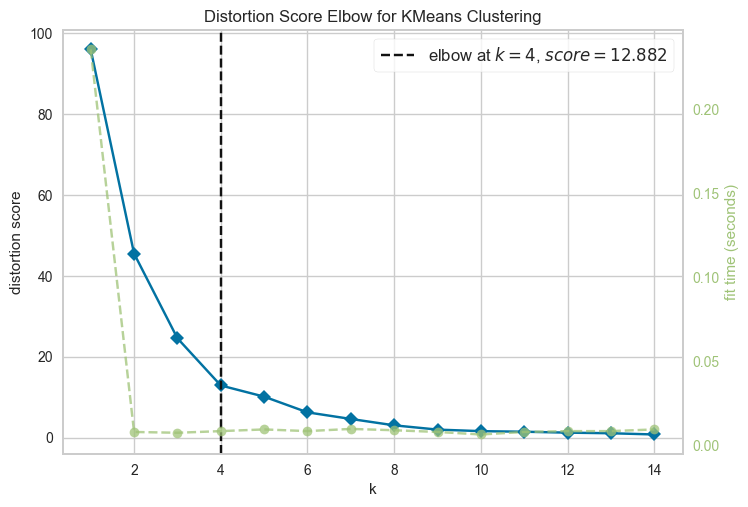

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [21]:
# Visualisation Elbow pour le choix de K pour kmeans

kmeans = KMeans(n_init="auto", random_state=123)

visualizer = KElbowVisualizer(kmeans, k=(1,15))


visualizer.fit(X_norm[['puissance', 'longueur', 'prix']])        # Fit the data to the visualizer

visualizer.show()        # Finalize and render the figure


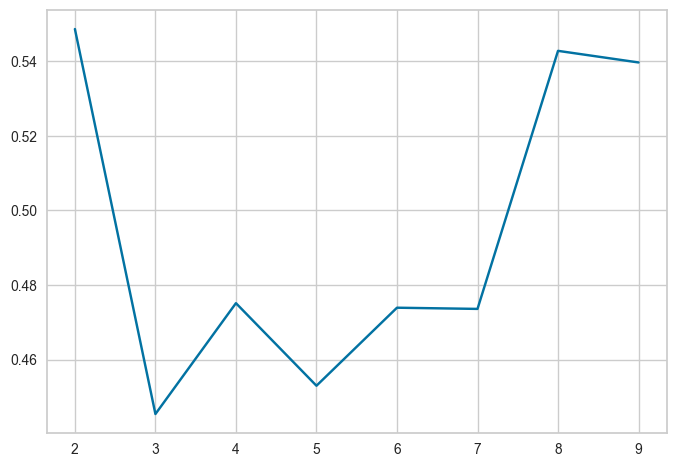

In [22]:
# Visualisation de Silhouette coef pour le choix de K
n_clusters = list (range (2, 10))
silhouettes = []
for k in n_clusters :
    kmeans = KMeans(n_clusters=k, random_state=123, n_init="auto")
    kmeans.fit(X_norm[['puissance','longueur', 'prix']])
    silhouettes.append (silhouette_score(X_norm[['puissance','longueur', 'prix']], kmeans.labels_))

plt.plot(n_clusters, silhouettes)

In [23]:
# Apply KMeans with K=5
kmeans = KMeans(n_clusters=4, random_state=123, n_init="auto")
kmeans.fit(X_norm[['puissance','longueur', 'prix']])

KMeans(n_clusters=4, random_state=123)

In [24]:
# Add the cluster labels to catalogue_new
catalogue_new['Cluster'] = kmeans.labels_

In [25]:
catalogue_new.head()

,marque,nom,puissance,longueur,nbPlaces,nbPortes,couleur,occasion,prix,Cluster
0,Volvo,S80 T6,272,3.0,5,5,blanc,False,50500,3
10,Volkswagen,Touran 2.0 FSI,150,2.0,7,5,rouge,False,27340,0
21,Volkswagen,Polo 1.2 6V,55,0.0,5,3,blanc,False,12200,1
35,Volkswagen,New Beatle 1.8,110,1.0,5,5,rouge,False,26630,0
45,Volkswagen,Golf 2.0 FSI,150,1.0,5,5,blanc,False,22900,0


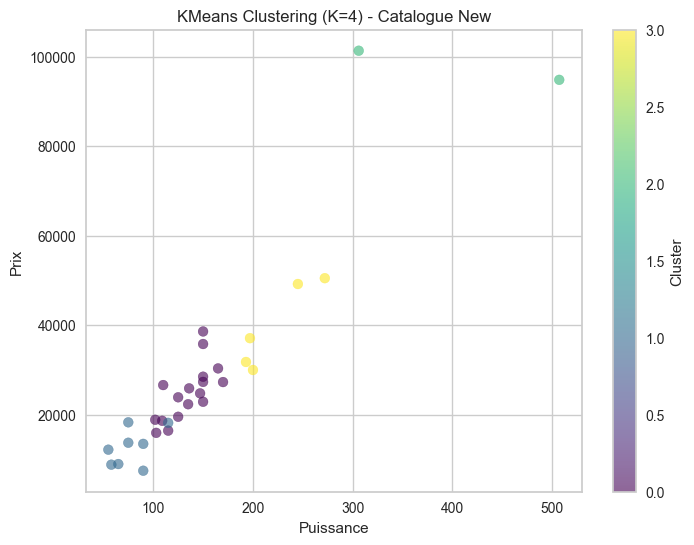

In [26]:
# Visualize the clusters in catalogue_new
plt.figure(figsize=(8, 6))

# Scatter plot of the first two features (you can choose any features for visualization)
plt.scatter(catalogue_new['puissance'], catalogue_new['prix'], c=catalogue_new['Cluster'], cmap='viridis', s=50, alpha=0.6)

plt.title('KMeans Clustering (K=4) - Catalogue New')
plt.xlabel('Puissance')
plt.ylabel('Prix')
plt.colorbar(label='Cluster')
plt.show()

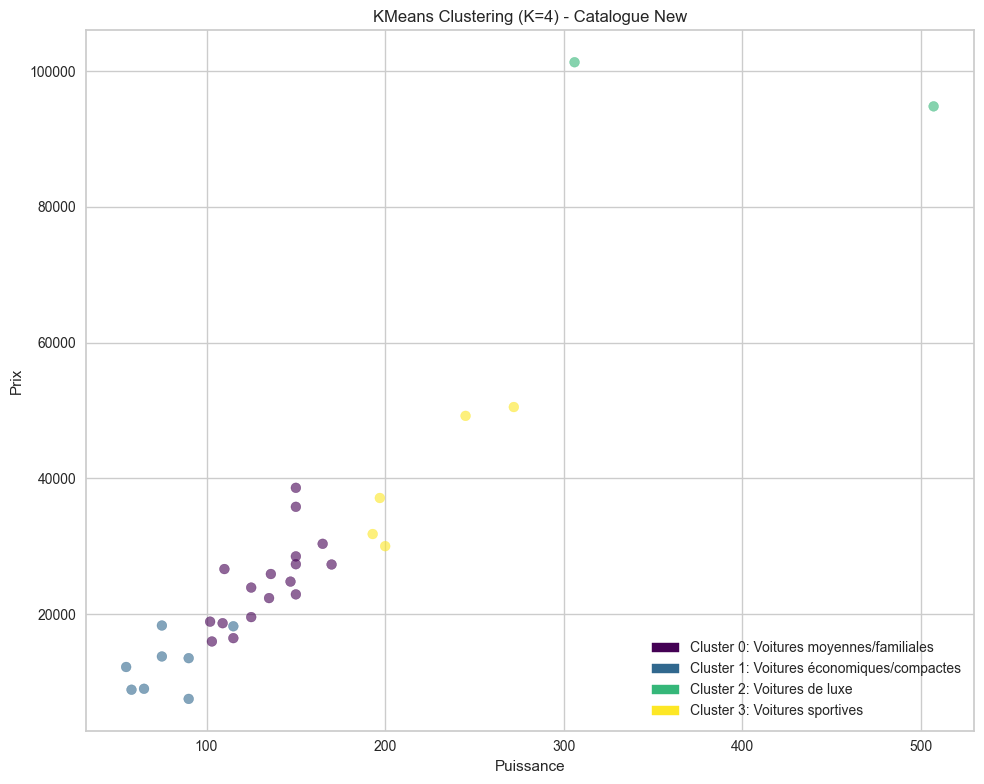

In [53]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Noms des clusters
cluster_names = {
    0: "Voitures moyennes/familiales" ,
    1: "Voitures économiques/compactes",
    2: "Voitures de luxe",
    3: "Voitures sportives"
}

# Créer une figure pour le graphique
plt.figure(figsize=(10, 8))

# Scatter plot des clusters en fonction de la puissance et du prix
scatter = plt.scatter(
    catalogue_new['puissance'], 
    catalogue_new['prix'], 
    c=catalogue_new['Cluster'], 
    cmap='viridis', 
    s=50, 
    alpha=0.6
)

# Ajouter des étiquettes et un titre
plt.title('KMeans Clustering (K=4) - Catalogue New')
plt.xlabel('Puissance')
plt.ylabel('Prix')

# Créer une légende avec les noms des clusters
colors = scatter.cmap(scatter.norm([0, 1, 2, 3]))  # Couleurs associées aux clusters
patches = [mpatches.Patch(color=colors[i], label=f"Cluster {i}: {cluster_names[i]}") for i in range(4)]
plt.legend(handles=patches, loc='lower right')

# Afficher la barre de couleurs et le graphique
# plt.colorbar(label='Cluster')
plt.tight_layout()  # Ajuste les marges pour éviter le chevauchement
plt.show()

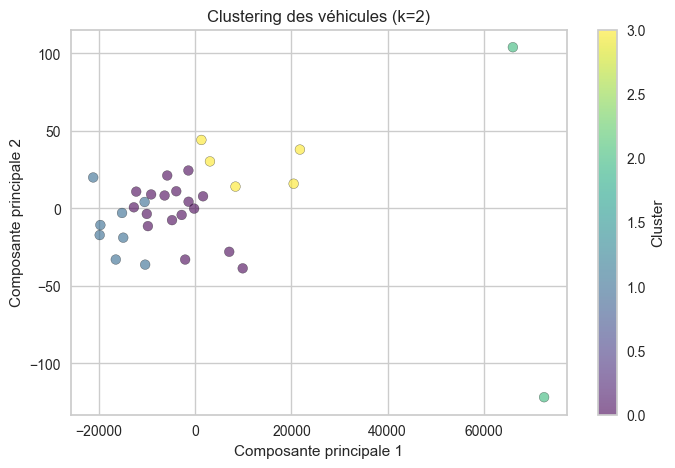

In [28]:
# Réduction de dimension pour visualisation
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
# Visualisation des clusters
plt.figure(figsize=(8, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=catalogue_new['Cluster'], cmap='viridis',
alpha=0.6, edgecolor='k')
plt.title('Clustering des véhicules (k=2)')
plt.xlabel('Composante principale 1')
plt.ylabel('Composante principale 2')
plt.colorbar(label='Cluster')
plt.show()


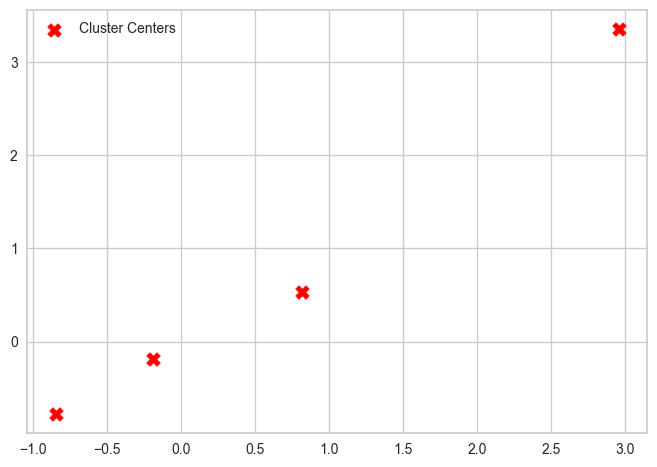

Cluster Centers (Centroids):
[[-0.1886891   0.08560081 -0.18449901]
 [-0.84913295 -1.33394594 -0.77818194]
 [ 2.96199896  1.45521375  3.35353277]
 [ 0.81535608  1.26118525  0.53097464]]


In [29]:
# Optionally, you can also visualize the cluster centers
cluster_centers = kmeans.cluster_centers_

# Plot the cluster centers on the same scatter plot
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 2], color='red', marker='X', s=100, label='Cluster Centers')
plt.legend()
plt.show()

# Display the cluster centers for interpretation
print("Cluster Centers (Centroids):")
print(cluster_centers)

In [30]:
tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3, random_state=42)
X_red = tsne.fit_transform(X_norm)

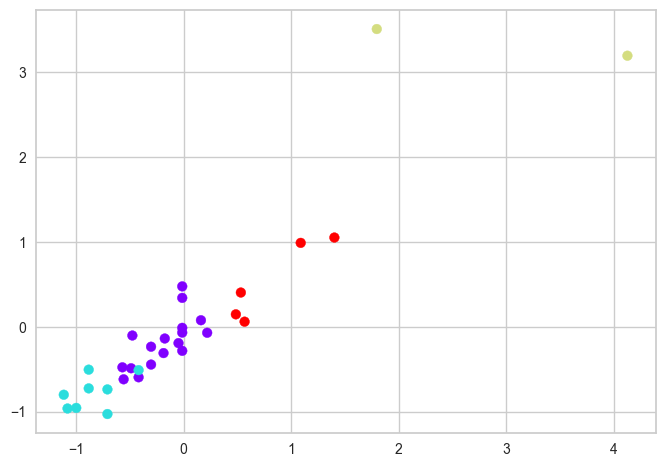

In [31]:
plt.scatter(X_norm["puissance"], X_norm["prix"], c=kmeans.labels_, cmap="rainbow")

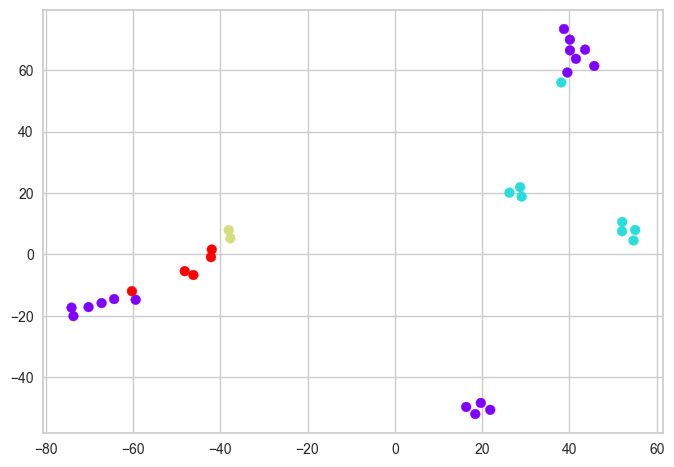

In [32]:
plt.scatter(X_red[:,0], X_red[:,1], c=kmeans.labels_, cmap="rainbow")

In [33]:
catalogue_new.to_csv("../data/clustered/catalogue_clusters.csv")

In [34]:
immatriculations = pd.read_csv("../data/processed/immatriculations_processed.csv")

#### Ajouter les clusters à immatriculations

In [35]:
immatriculations.head()

,immatriculation,marque,nom,puissance,longueur,nbPlaces,nbPortes,couleur,occasion,prix
0,3467 SB 72,Seat,Toledo 1.6,102,longue,5,5,bleu,False,18880
1,113 LY 42,Renault,Vel Satis 3.5 V6,245,très longue,5,5,noir,False,49200
2,925 WK 87,Jaguar,X-Type 2.5 V6,197,longue,5,5,blanc,False,37100
3,3279 RV 81,Renault,Laguna 2.0T,170,longue,5,5,gris,False,27300
4,82 RZ 54,Fiat,Croma 2.2,147,longue,5,5,bleu,False,24780


In [36]:
len(immatriculations)

99989

In [37]:
# Extraire uniquement les colonnes pertinentes du catalogue contenant les informations des clusters
catalogue_clusters = catalogue_new[['marque', 'nom', 'Cluster']]  # Colonnes marque, nom et Cluster

In [38]:
# Fusionner les clusters du catalogue avec les immatriculations sur les colonnes 'marque' et 'nom'
immatriculations_with_clusters = immatriculations.merge(
    catalogue_clusters, 
    on=['marque', 'nom'],  # Jointure sur les colonnes 'marque' et 'nom'
    how='left'  # Utilisation d'une jointure 'left' pour conserver toutes les lignes de immatriculations
)

In [39]:
# Afficher les premières lignes du tableau immatriculations avec les clusters ajoutés
print(immatriculations_with_clusters.head())

  immatriculation   marque               nom  puissance     longueur  \
0      3467 SB 72     Seat        Toledo 1.6        102       longue   
1       113 LY 42  Renault  Vel Satis 3.5 V6        245  très longue   
2       925 WK 87   Jaguar     X-Type 2.5 V6        197       longue   
3      3279 RV 81  Renault       Laguna 2.0T        170       longue   
4        82 RZ 54     Fiat         Croma 2.2        147       longue   

   nbPlaces  nbPortes couleur  occasion   prix  Cluster  
0         5         5    bleu     False  18880        0  
1         5         5    noir     False  49200        3  
2         5         5   blanc     False  37100        3  
3         5         5    gris     False  27300        0  
4         5         5    bleu     False  24780        0  


In [40]:
len(immatriculations)

99989

In [41]:
immatriculations_with_clusters = immatriculations_with_clusters[immatriculations_with_clusters["occasion"]==False]
len(immatriculations_with_clusters)

68638

In [42]:
#Sauvegarder le tableau mis à jour dans un fichier CSV
immatriculations_with_clusters.to_csv('../data/clustered/immatriculations_clusters.csv', index=False)
